# Explainability with Amazon SageMaker Debugger
_**Explain a XGBoost model that predicts an individual's income**_

This notebook demonstrates how to use Amazon SageMaker Debugger to capture the feature importance and SHAP values for a XGBoost model.

This notebook was created and tested on an ml.t2.medium notebook instance.

**Table of Contents** 

1. [Introduction](#intro)
2. [Section 1 - Setup](#setup)
3. [Section 2 - Prepare Data](#prep-data)
4. [Section 3 - Train XGBoost model with Amazon SageMaker with debugger enabled](#train)
5. [Section 4 - Analyze debugger output](#analyze-debugger-ouput)
6. [Clean up](#cleanup)


## Introduction <a id='intro'></a>

Amazon SageMaker Debugger is a new capability of Amazon SageMaker that allows debugging machine learning training. The capability helps you monitor the training jobs in near real time using rules and alert you once it has detected inconsistency in training. 

Using Amazon SageMaker Debugger is a two step process: Saving tensors and Analysis.
Let's look at each one of them closely.

### Saving tensors

In deep learning algorithms, tensors define the state of the training job at any particular instant in its lifecycle.  Amazon SageMaker Debugger exposes a library which allows you to capture these tensors and save them for analysis.

Although XGBoost is not a deep learning algorithm, Amazon SageMaker Debugger is highly customizable and can help provide interpretability by saving insightful metrics, such as performance metrics or feature importances, at different frequencies.
Refer to [documentation](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/xgboost.md) for details on how to save the metrics you want.

Metrics saved can also include feature importance and SHAP values for all features in the dataset. TODO : Add links to the collections / metrics collected.  The feature importance and SHAP values collected are what we will use to provide local and global explainability.


### Analysis

After the tensors are saved, perform automatic analysis by running debugging ***Rules***.
On a very broad level, a rule is Python code used to detect certain conditions during training.
Some of the conditions that a data scientist training an algorithm may care about are monitoring for gradients getting too large or too small, detecting overfitting, and so on.
Amazon SageMaker Debugger comes pre-packaged with certain rules that can be invoked on Amazon SageMaker. Users can also write their own rules using the Amazon SageMaker Debugger APIs. 
For more information about automatic analysis using a rule, see the [rules documentation](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/analysis.md).
 

## Section 1 - Setup <a id='setup'></a>

In this section, we will import the necessary libraries, setup variables and examine dataset used. that was used to train the XGBoost model to predict an individual's income.

Let's start by specifying:

* The AWS region used to host your model.
* The IAM role associated with this SageMaker notebook instance.
* The S3 bucket used to store the data used to train the model, save debugger information during training and the trained model artifact.

### 1.1 Install the 'smdebug' open source library

In [95]:
! python -m pip install smdebug

awscli 1.16.283 has requirement botocore==1.13.19, but you'll have botocore 1.14.0 which is incompatible.
awscli 1.16.283 has requirement s3transfer<0.3.0,>=0.2.0, but you'll have s3transfer 0.3.0 which is incompatible.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### 1.2 Import necessary libraries

In [96]:
import boto3
import sagemaker
import os

from sagemaker import get_execution_role

### 1.3 AWS region and  IAM Role

In [97]:
region = boto3.Session().region_name
print("AWS Region: {}".format(region))

role = get_execution_role()
print("RoleArn: {}".format(role))

AWS Region: us-west-2
RoleArn: arn:aws:iam::555360056434:role/service-role/AmazonSageMaker-ExecutionRole-20191218T131705


### 1.4 S3 bucket and prefix to hold training data, debugger information and model artifact

In [98]:
bucket = sagemaker.Session().default_bucket()
prefix = "DEMO-smdebug-xgboost-adult-income-prediction"

Amazon SageMaker Debugger is available in Amazon SageMaker XGBoost container version 0.90-2 or later. If you want to use XGBoost with Amazon SageMaker Debugger, you have to specify `repo_version='0.90-2'` in the `get_image_uri` function.

In [99]:
from sagemaker.amazon.amazon_estimator import get_image_uri

# Below changes the Region to be one where this notebook is running
#region = boto3.Session().region_name

container = get_image_uri(region, "xgboost", repo_version="0.90-2")

## Section 2 - Data preparation <a id='prep-data'></a>

In [ ]:
#bucket = sagemaker.Session().default_bucket()
#prefix = "DEMO-smdebug-xgboost-adult-income-prediction"

In [100]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test

--2020-01-30 20:57:48--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data.9’

adult.data.9        100%[===================>]   3.79M  13.0MB/s    in 0.3s    

2020-01-30 20:57:48 (13.0 MB/s) - ‘adult.data.9’ saved [3974305/3974305]

--2020-01-30 20:57:48--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2003153 (1.9M) [application/x-httpd-php]
Saving to: ‘adult.test.9’

adult.test.9        100%[===================>]   1.91M  7.55MB/s    in 0.3s    

In [101]:
import pandas as pd

FEATURES = (
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income-level'
)

# Load the training census dataset
census_data_filename = 'adult.data'
with open(census_data_filename, 'r') as train_data_file:
    raw_training_data = pd.read_csv(train_data_file, header=None, names=FEATURES)

categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income-level']

data_dummy = pd.get_dummies(raw_training_data, prefix=categorical_features, 
                            columns=categorical_features, drop_first=True)
data_dummy.head(100)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,...,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,income-level_ >50K
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,38,215646,9,0,0,40,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,53,234721,7,0,0,40,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,28,338409,13,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,37,284582,14,0,0,40,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
6,49,160187,5,0,0,16,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,52,209642,9,0,0,45,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
8,31,45781,14,14084,0,50,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
9,42,159449,13,5178,0,40,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1


In [102]:
from sklearn.model_selection import train_test_split   # For splitting the dataset

y = data_dummy.loc[:, "income-level_ >50K"]
X = data_dummy.drop("income-level_ >50K", axis=1)
# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Use 'csv' format to store the data
# The first column is expected to be the output column
pd.concat([y_train, X_train], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([y_test, X_test], axis=1).to_csv('validation.csv', index=False, header=False)

In [103]:
%%time
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'data/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'data/validation.csv')).upload_file('validation.csv')

CPU times: user 155 ms, sys: 33.2 ms, total: 188 ms
Wall time: 421 ms


## Section 3 - Train XGBoost model in Amazon SageMaker with  debugger enabled. <a id='train'></a>

Now train an XGBoost model with Amazon SageMaker Debugger enabled and monitor the training jobs. This is done using the Amazon SageMaker Estimator API. While the training job is running, use Amazon SageMaker Debugger API to access saved tensors in real time and visualize them. You can rely on Amazon SageMaker Debugger to take care of downloading a fresh set of tensors every time you query for them.

Amazon SageMaker Debugger is available in Amazon SageMaker XGBoost container version 0.90-2 or later. If you want to use XGBoost with Amazon SageMaker Debugger, you have to specify `repo_version='0.90-2'` in the `get_image_uri` function.

In [104]:
from sagemaker.amazon.amazon_estimator import get_image_uri

# Below changes the Region to be one where this notebook is running
#region = boto3.Session().region_name

container = get_image_uri(region, "xgboost", repo_version="0.90-2")

In [105]:
#from sagemaker import get_execution_role
#role = get_execution_role()

base_job_name = "demo-smdebug-xgboost-adult-income-prediction-classification"
bucket_path = 's3://{}'.format(bucket)

hyperparameters={
    "max_depth": "5",
    "eta": "0.2",
    "gamma": "4",
    "min_child_weight": "6",
    "subsample": "0.7",
    "silent": "0",
    "objective": "binary:logistic",
    "num_round": "51",
}

save_interval = 10

### Enabling Debugger in Estimator object


#### DebuggerHookConfig

Enabling Amazon SageMaker Debugger in training job can be accomplished by adding its configuration into Estimator object constructor:

```python
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig

estimator = Estimator(
    ...,
    debugger_hook_config = DebuggerHookConfig(
        s3_output_path="s3://{bucket_name}/{location_in_bucket}",  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": "10"
                }
            )
        ]
    )
)
```
Here, the `DebuggerHookConfig` object instructs `Estimator` what data we are interested in.
Two parameters are provided in the example:

- `s3_output_path`: it points to S3 bucket/path where we intend to store our debugging tensors.
  Amount of data saved depends on multiple factors, major ones are: training job / data set / model / frequency of saving tensors.
  This bucket should be in your AWS account, and you should have full access control over it.
  **Important Note**: this s3 bucket should be originally created in the same region where your training job will be running, otherwise you might run into problems with cross region access.

- `collection_configs`: it enumerates named collections of tensors we want to save.
  Collections are a convinient way to organize relevant tensors under same umbrella to make it easy to navigate them during analysis.
  In this particular example, you are instructing Amazon SageMaker Debugger that you are interested in a single collection named `metrics`.
  We also instructed Amazon SageMaker Debugger to save metrics every 10 iteration.
  See [Collection](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/api.md#collection) documentation for all parameters that are supported by Collections and DebuggerConfig documentation for more details about all parameters DebuggerConfig supports.
  
#### Rules

Enabling Rules in training job can be accomplished by adding the `rules` configuration into Estimator object constructor.

- `rules`: This new parameter will accept a list of rules you wish to evaluate against the tensors output by this training job.
  For rules, Amazon SageMaker Debugger supports two types:
  - SageMaker Rules: These are rules specially curated by the data science and engineering teams in Amazon SageMaker which you can opt to evaluate against your training job.
  - Custom Rules: You can optionally choose to write your own rule as a Python source file and have it evaluated against your training job.
    To provide Amazon SageMaker Debugger to evaluate this rule, you would have to provide the S3 location of the rule source and the evaluator image.

In this example, you will use a Amazon SageMaker's LossNotDecreasing rule, which helps you identify if you are running into a situation where the training loss is not going down.

```python
from sagemaker.debugger import rule_configs, Rule

estimator = Estimator(
    ...,
    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": "10",
            },
        ),
    ],
)
```

- `rule_parameters`: In this parameter, you provide the runtime values of the parameter in your constructor.
  You can still choose to pass in other values which may be necessary for your rule to be evaluated.
  In this example, you will use Amazon SageMaker's LossNotDecreasing rule to monitor the `metircs` collection.
  The rule will alert you if the tensors in `metrics` has not decreased for more than 10 steps.

**Q: Should we still collect feature importance?**

In [106]:
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig, CollectionConfig
from sagemaker.estimator import Estimator

xgboost_estimator = Estimator(
    role=role,
    base_job_name=base_job_name,
    train_instance_count=1,
    train_instance_type='ml.m4.4xlarge',
    image_name=container,
    hyperparameters=hyperparameters,
    train_max_run=1800,

    debugger_hook_config=DebuggerHookConfig(
        s3_output_path=bucket_path,  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="feature_importance",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="average_shap",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
        ],
    ),

    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": str(save_interval * 2),
            },
        ),
    ],
)

With the next step, start a training job by using the Estimator object you created above. This job is started in an asynchronous, non-blocking way. This means that control is passed back to the notebook and further commands can be run while the training job is progressing.

In [107]:
from sagemaker.session import s3_input

train_input = s3_input("s3://{}/{}/{}".format(bucket, prefix, "data/train.csv"), content_type="csv")
validation_input = s3_input( "s3://{}/{}/{}".format(bucket, prefix, "data/validation.csv"), content_type="csv")
xgboost_estimator.fit(
    {"train": train_input, "validation": validation_input},
    # This is a fire and forget event. By setting wait=False, you just submit the job to run in the background.
    # Amazon SageMaker starts one training job and release control to next cells in the notebook.
    # Follow this notebook to see status of the training job.
    wait=False
)

### Result

As a result of the above command, Amazon SageMaker starts **one training job and one rule job** for you. The first one is the job that produces the tensors to be analyzed. The second one analyzes the tensors to check if `train-rmse` and `validation-rmse` are not decreasing at any point during training.

Check the status of the training job below.
After your training job is started, Amazon SageMaker starts a rule-execution job to run the LossNotDecreasing rule.

**Note that the next cell blocks until the rule execution job ends. You can stop it at any point to proceed to the rest of the notebook. Once it says Rule Evaluation Status is Started, and shows the `RuleEvaluationJobArn`, you can look at the status of the rule being monitored.**

In [108]:
import time

for _ in range(36):
    job_name = xgboost_estimator.latest_training_job.name
    client = xgboost_estimator.sagemaker_session.sagemaker_client
    description = client.describe_training_job(TrainingJobName=job_name)
    training_job_status = description["TrainingJobStatus"]
    rule_job_summary = xgboost_estimator.latest_training_job.rule_job_summary()
    rule_evaluation_status = rule_job_summary[0]["RuleEvaluationStatus"]
    print("Training job status: {}, Rule Evaluation Status: {}".format(training_job_status, rule_evaluation_status))

    if rule_evaluation_status in ["Stopped", "IssuesFound", "NoIssuesFound"]:
        break

    time.sleep(25)

Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress
Training job status: Completed, Rule Evaluation Status: InProgress


KeyboardInterrupt: 

### Check the status of the Rule Evaluation Job

To get the rule evaluation job that Amazon SageMaker started for you, run the command below. The results show you the `RuleConfigurationName`, `RuleEvaluationJobArn`, `RuleEvaluationStatus`, `StatusDetails`, and `RuleEvaluationJobArn`.
If the tensors meets a rule evaluation condition, the rule execution job throws a client error with `RuleEvaluationConditionMet`.

The logs of the rule evaluation job are available in the Cloudwatch Logstream `/aws/sagemaker/ProcessingJobs` with `RuleEvaluationJobArn`.

You can see that once the rule execution job starts, it identifies the loss not decreasing situation in the training job, it raises the `RuleEvaluationConditionMet` exception, and it ends the job.

In [109]:
xgboost_estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-west-2:555360056434:processing-job/demo-smdebug-xgboost-adult-lossnotdecreasing-b579ed68',
  'RuleEvaluationStatus': 'InProgress',
  'LastModifiedTime': datetime.datetime(2020, 1, 30, 21, 3, 1, 335000, tzinfo=tzlocal())}]

## Section 4 - Analyze debugger output <a id='analyze-debugger-ouput'></a>

Now that you've trained the system, analyze the data.  Here, you focus on after-the-fact analysis.

You import a basic analysis library, which defines the concept of trial, which represents a single training run.

**Question : Debugger output is showing up in the s3 bucket only after the training job is complete.  Should we be seeing the output during training?  For our purpose of Explainability, post training analysis might be ok and sufficient??**

In [110]:
from smdebug.trials import create_trial

s3_output_path = xgboost_estimator.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2020-01-30 21:03:23.438 ip-172-16-49-19:2539 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-west-2-555360056434/demo-smdebug-xgboost-adult-income-predi-2020-01-30-20-58-13-457/debug-output


You can list all the tensors that you know something about. Each one of these names is the name of a tensor. The name is a combination of the feature name, which in these cases, is auto-assigned by XGBoost, and whether it's an evaluation metric, feature importance, or SHAP value.

**Question : Why are they so many features, when we trained with only 15?** 


**Q : Do these corresponding to the one-hot-encoded values?  Or do we always have 100 features in the avg SHAP Collection?**


**Q : Features in the average_shap and feature_importance collections seem to be different??** 

In [111]:
trial.tensor_names()

[2020-01-30 21:03:37.646 ip-172-16-49-19:2539 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2020-01-30 21:03:38.674 ip-172-16-49-19:2539 INFO trial.py:209] Loaded all steps


['average_shap/f0',
 'average_shap/f1',
 'average_shap/f10',
 'average_shap/f11',
 'average_shap/f12',
 'average_shap/f13',
 'average_shap/f14',
 'average_shap/f15',
 'average_shap/f16',
 'average_shap/f17',
 'average_shap/f18',
 'average_shap/f19',
 'average_shap/f2',
 'average_shap/f20',
 'average_shap/f21',
 'average_shap/f22',
 'average_shap/f23',
 'average_shap/f24',
 'average_shap/f25',
 'average_shap/f26',
 'average_shap/f27',
 'average_shap/f28',
 'average_shap/f29',
 'average_shap/f3',
 'average_shap/f30',
 'average_shap/f31',
 'average_shap/f32',
 'average_shap/f33',
 'average_shap/f34',
 'average_shap/f35',
 'average_shap/f36',
 'average_shap/f37',
 'average_shap/f38',
 'average_shap/f39',
 'average_shap/f4',
 'average_shap/f40',
 'average_shap/f41',
 'average_shap/f42',
 'average_shap/f43',
 'average_shap/f44',
 'average_shap/f45',
 'average_shap/f46',
 'average_shap/f47',
 'average_shap/f48',
 'average_shap/f49',
 'average_shap/f5',
 'average_shap/f50',
 'average_shap/f51'

For each tensor, ask for the steps where you have data. In this case, every five steps

In [112]:
trial.tensor("train-error").steps()

[0, 10, 20, 30, 40, 50]

You can obtain each tensor at each step as a NumPy array.

In [113]:
trial.tensor("train-error").value(10)

array([0.140241])

In [114]:
trial.tensor("feature_importance/total_gain/f1").steps()

[10, 20, 30, 40, 50]

In [115]:
trial.tensor("average_shap/f1").steps()

[0, 10, 20, 30, 40, 50]

In [116]:
trial.tensor("average_shap/f1").values()

{0: array([0.], dtype=float32),
 10: array([0.00012783], dtype=float32),
 20: array([0.00124425], dtype=float32),
 30: array([0.00076909], dtype=float32),
 40: array([0.00096108], dtype=float32),
 50: array([0.00159957], dtype=float32)}

### Plot Performance metrics

You can also create a simple function that visualizes the training and validation errors as the training progresses.
Each gradient should get smaller over time, as the system converges to a good solution.
Remember that this is an interactive analysis. You are showing these tensors to give an idea of the data.

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
import re

MAX_PLOTS = 35
from itertools import islice

def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

def plot_collection(trial, collection_name, regex='.*', figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and 
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.despine()

    tensors = trial.collection(collection_name).tensor_names
    matched_tensors = [t for t in tensors if re.match(regex, t)]
    for tensor_name in islice(matched_tensors, MAX_PLOTS):
        steps, data = get_data(trial, tensor_name)
        ax.plot(steps, data, label=tensor_name)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Iteration')

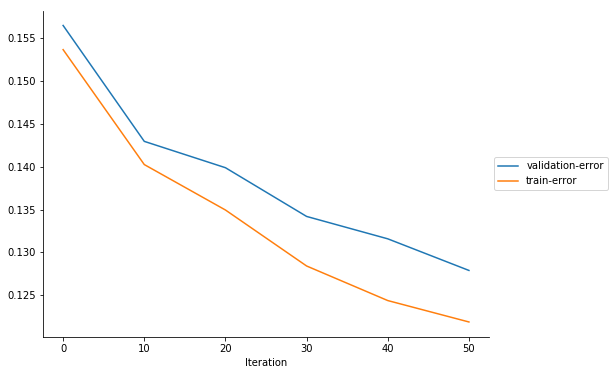

In [118]:
plot_collection(trial, "metrics")

### Feature importances

You can also visualize the feature priorities as determined by
[xgboost.get_score()](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score).
If you instructed Estimator to log the `feature_importance` collection, all five importance types supported by `xgboost.get_score()` will be available in the collection.

In [119]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(
        trial,
        "feature_importance",
        regex=f"feature_importance/{importance_type}/.*")    

**Question : Why only a few feature showing up in this plot, if the regex used is '*'**

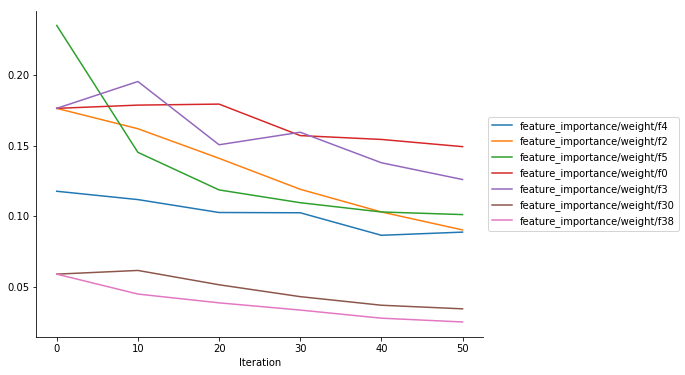

In [120]:
plot_feature_importance(trial)

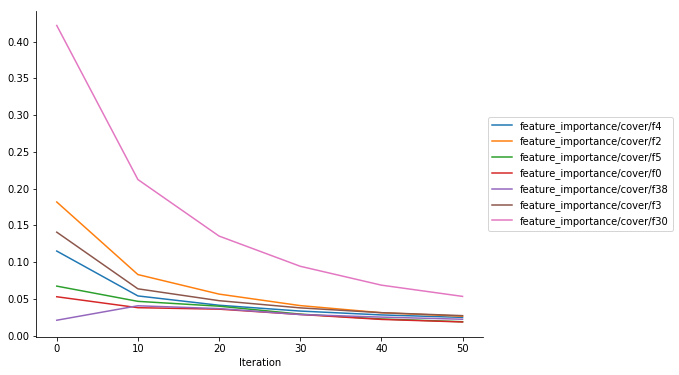

In [121]:
plot_feature_importance(trial, importance_type="cover")

### SHAP

[SHAP](https://github.com/slundberg/shap) (SHapley Additive exPlanations) is
another approach to explain the output of machine learning models.
SHAP values represent a feature's contribution to a change in the model output.
You instructed Estimator to log the average SHAP values in this example so the SHAP values (as calculaged by [xgboost.predict(pred_contribs=True)](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.predict)) will be available the `average_shap` collection.

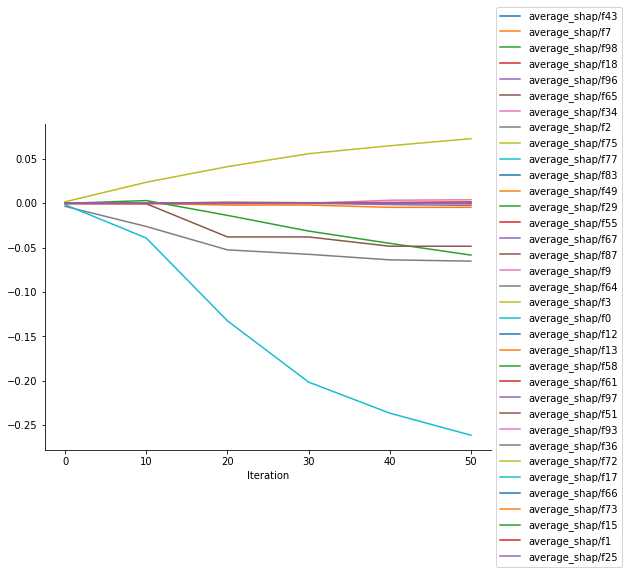

In [122]:
plot_collection(trial,"average_shap")

#### Sireesha - Adding additional analysis below to see if we can show SHAP values better

**Q : Can I use the mean of the average_shap values from all steps?  Or is there another metric that already captures this?**

**Q : What values does the SHAP value at each iteration provide?**

In [138]:
## Get the average shap value for each feature.
from pandas import Series

features = []
features_avg_shap = []

for tensor in  tensors: 
    #print(tensor)
    feature = tensor.split("/")[1]
    
    feature_shap_values = trial.tensor(tensor).values()
    #print(feature_shap_values)
    avg_feature_shap = Series([feature_shap_values[k] for k in feature_shap_values]).mean()[0]
    
    if avg_feature_shap != 0.0 :
        features.append(feature)
        features_avg_shap.append(avg_feature_shap)
        
        print("feature ", feature, " avg_feature_shap : " , avg_feature_shap)

feature  f7  avg_feature_shap :  -3.925416e-05
feature  f34  avg_feature_shap :  0.0012675824
feature  f2  avg_feature_shap :  -0.04466331
feature  f49  avg_feature_shap :  -0.002130153
feature  f55  avg_feature_shap :  5.0869134e-05
feature  f9  avg_feature_shap :  0.00032855917
feature  f3  avg_feature_shap :  0.043459926
feature  f0  avg_feature_shap :  -0.14534348
feature  f58  avg_feature_shap :  -0.024147673
feature  f97  avg_feature_shap :  -0.00060985214
feature  f51  avg_feature_shap :  -0.028777083
feature  f1  avg_feature_shap :  0.0007836365
feature  f27  avg_feature_shap :  -0.00023655807
feature  f46  avg_feature_shap :  -0.0005337642
feature  f47  avg_feature_shap :  -0.0014494226
feature  f32  avg_feature_shap :  -0.015120487
feature  f44  avg_feature_shap :  -0.004793515
feature  f42  avg_feature_shap :  -0.016034236
feature  f30  avg_feature_shap :  -0.1329532
feature  f10  avg_feature_shap :  -0.0018638041
feature  f37  avg_feature_shap :  -0.0021067406
feature  f39 

In [ ]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

##Using the below as a smaple to show the bar graph.
#objects = ('Python', 'C++', 'Java', 'Perl', 'Scala', 'Lisp')
#type(objects)

#y_pos = np.arange(len(objects))
#performance = [10,8,6,4,2,1]

#plt.barh(y_pos, performance, align='center', alpha=0.5)
#plt.yticks(y_pos, objects)
#plt.xlabel('Usage')
#plt.title('Programming language usage')

#plt.show()

**TODO : Only showing 25 features for simplicity and clear graph.  Should we sort by shap values to show only top 20/25?**

**Q : How do we get the actualy feature names??**

**Q : Is this the right graph to demonstrate global explainability.  If so we need to add content/analysis to make it clear**


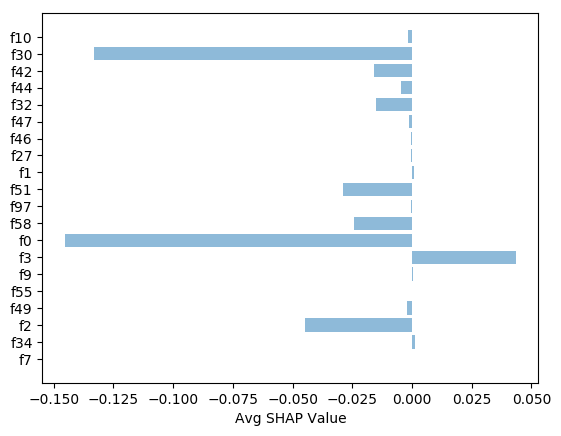

In [148]:
objects = features[0:20]
y_pos = np.arange(len(objects))

performance = features_avg_shap[0:20]

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Avg SHAP Value')
plt.show()